In [12]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [92]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t = sp.symbols('k omega p_0 p_0_x phi v x t')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.cos(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, p_0, phi, C = parameters
    return p_0*np.cos(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k)

In [77]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0
def invals_vastex(x,y):
    return [0,0,0,0]

In [140]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    def invals_amplitude(x,y):
        if invals is None:
            return [0,0,0,0]
        else:
            return invals
    
    P_0_x = []
    omega_x = []
    for xval in range(len(X)):
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout)
        print('\n\n')
        print(tijdfit, 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        #plot het boeltje om te testen
        fig, ax = plt.subplots(1,1)
        ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', linestyle = ' ', marker = 'o',zorder = 1)
        T_fit = np.linspace(0, max(tijd),300)
        druk_fit = tijdfit[1][0]*np.cos(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
        ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)
        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('T (s)')
        ax.legend("druk in functie van tijd")
        ax.legend()
        plt.tight_layout()
        plt.show()


    OMEGA = functies.mu_sigma(omega_x, omega)

    
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR):
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_vastex, X, P_0_x, P_0_x_ERR)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR))

    x_fit = np.linspace(0,max(X))
    druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
    #plot het boeltje
    fig, ax = plt.subplots(1,1)
    ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')

    ax.plot(x_fit, druk_fit, label = 'model')

    ax.set_ylabel('$V_0$ [mV]')
    ax.set_xlabel('x (m)')
    ax.legend("drukamplitude in functie van positie")
    ax.legend()
    plt.tight_layout()
    plt.show()

    #bereken de snelheid
    snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)
    print(snelheid)

In [ ]:
#### Hier volgt de effectieve data-analyse
fix_data(X, T, P, P_fout)

In [131]:
def X_tractor(inhoud): #extraheert effectief nuttige data uit die txt-files
    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak
    freq = float(inhoud.split("Frequency            :		")[1][:4]) * 10**3 #het staat in kHz
    phi = 0 #ja bro idk
    invals = [4*np.pi*freq, amplitude, phi]
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    for digit in gesplit[1]:
        if digit.isdigit():
            getal+=digit
        else:
            eenheid+=digit
            count+=1
        if count == 3:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == ".us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == ".ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    Vpart = np.array(nuttig[1])
    invals.append(np.sum(Vpart)/len(Vpart)) #neem als afschatting voor de +C het gemiddelde
    return T, Vpart, eenheid, invals

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11988277166.043623
             x: [ 1.747e+04 -1.629e+01  5.665e-03 -1.812e+00]
           nit: 357
          nfev: 709
 final_simplex: (array([[ 1.747e+04, -1.629e+01,  5.665e-03, -1.812e+00],
                       [ 1.747e+04, -1.629e+01,  5.665e-03, -1.812e+00],
                       ...,
                       [ 1.747e+04, -1.629e+01,  5.665e-03, -1.812e+00],
                       [ 1.747e+04, -1.629e+01,  5.665e-03, -1.812e+00]]), array([ 1.199e+10,  1.199e+10,  1.199e+10,  1.199e+10,
                        1.199e+10]))
[[8733.597552149484, 26200.79432317388], [-19.292449203077375, -16.287202965080265], [0.005665130013594643, 0.005665130014045104], [-1.8117118590849852, -1.8117118590846377]]
omega heeft als waarde: 17467 + 8733.6 - 8733.6 met 68% betrouwbaarheidsinterval: [8733.6, 26201] 
p_0_x heeft als waarde: -16.287 + 3.1116e-06 - 3.0052 met 68% betrouwb

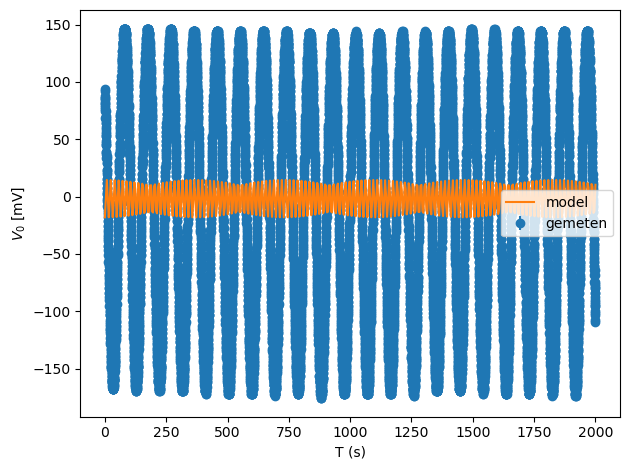

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 144015002.6435237
             x: [ 2.077e+04 -1.736e+01  2.629e-03  8.485e+00]
           nit: 324
          nfev: 643
 final_simplex: (array([[ 2.077e+04, -1.736e+01,  2.629e-03,  8.485e+00],
                       [ 2.077e+04, -1.736e+01,  2.629e-03,  8.485e+00],
                       ...,
                       [ 2.077e+04, -1.736e+01,  2.629e-03,  8.485e+00],
                       [ 2.077e+04, -1.736e+01,  2.629e-03,  8.485e+00]]), array([ 1.440e+08,  1.440e+08,  1.440e+08,  1.440e+08,
                        1.440e+08]))
[[10382.165775956537, 31149.25185060893], [-17.463435402945997, -17.358089762043473], [0.0026290035075087156, 0.0026290035155402576], [7.012294249532629, 8.485151645631605]]
omega heeft als waarde: 20766 + 10383 - 10384 met 68% betrouwbaarheidsinterval: [10382, 31149] 
p_0_x heeft als waarde: -17.358 + 8.9531e-05 - 0.10526 met 68% betrouwbaarh

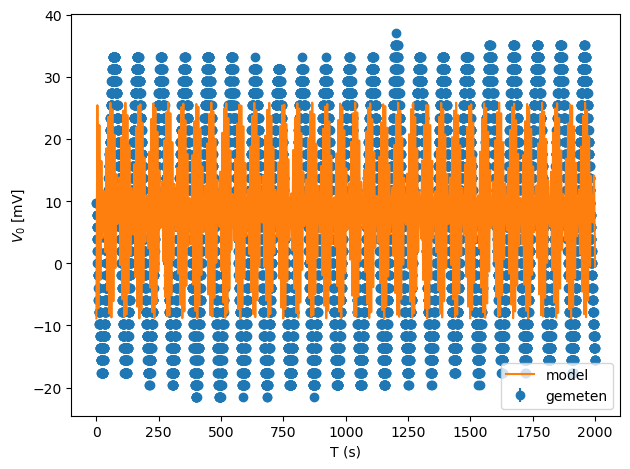

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1477148621.507504
             x: [ 1.963e+04 -2.159e+01  1.494e-02 -7.068e+00]
           nit: 391
          nfev: 780
 final_simplex: (array([[ 1.963e+04, -2.159e+01,  1.494e-02, -7.068e+00],
                       [ 1.963e+04, -2.159e+01,  1.494e-02, -7.068e+00],
                       ...,
                       [ 1.963e+04, -2.159e+01,  1.494e-02, -7.068e+00],
                       [ 1.963e+04, -2.159e+01,  1.494e-02, -7.068e+00]]), array([ 1.477e+09,  1.477e+09,  1.477e+09,  1.477e+09,
                        1.477e+09]))
[[9817.411054026983, 29452.4432181445], [-21.592438666820584, -21.592438666820566], [0.01493803510015308, 0.014938035062581657], [-7.067621161377033, -7.067621161377018]]
omega heeft als waarde: 19635 + 9817.6 - 9817.5 met 68% betrouwbaarheidsinterval: [9817.4, 29452] 
p_0_x heeft als waarde: -21.592 + 3.6897e-07 - -3.6897e-07 met 68% betrouwb

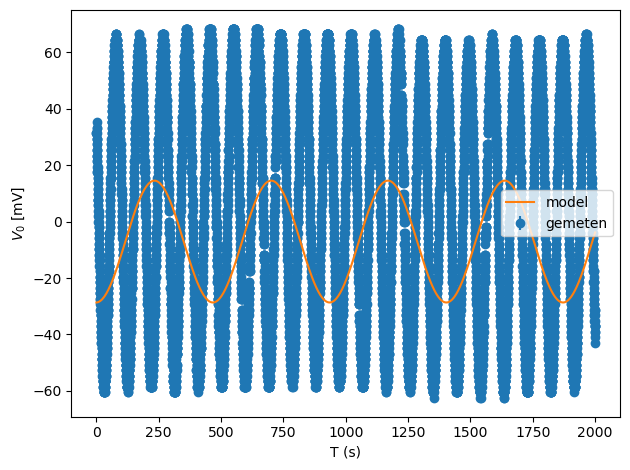

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2517695131.103383
             x: [ 2.161e+04 -4.148e+01  5.441e-03 -3.446e+00]
           nit: 347
          nfev: 697
 final_simplex: (array([[ 2.161e+04, -4.148e+01,  5.441e-03, -3.446e+00],
                       [ 2.161e+04, -4.148e+01,  5.441e-03, -3.446e+00],
                       ...,
                       [ 2.161e+04, -4.148e+01,  5.441e-03, -3.446e+00],
                       [ 2.161e+04, -4.148e+01,  5.441e-03, -3.446e+00]]), array([ 2.518e+09,  2.518e+09,  2.518e+09,  2.518e+09,
                        2.518e+09]))
[[10807.032821193266, 32421.141341722985], [-45.78134270558824, -41.47566548036559], [0.005440563876871615, 0.005440563865931403], [-3.4464422630479197, -3.4464422630478975]]
omega heeft als waarde: 21614 + 10807 - 10807 met 68% betrouwbaarheidsinterval: [10807, 32421] 
p_0_x heeft als waarde: -41.476 + 2.1766e-06 - 4.3057 met 68% betrouwbaarh

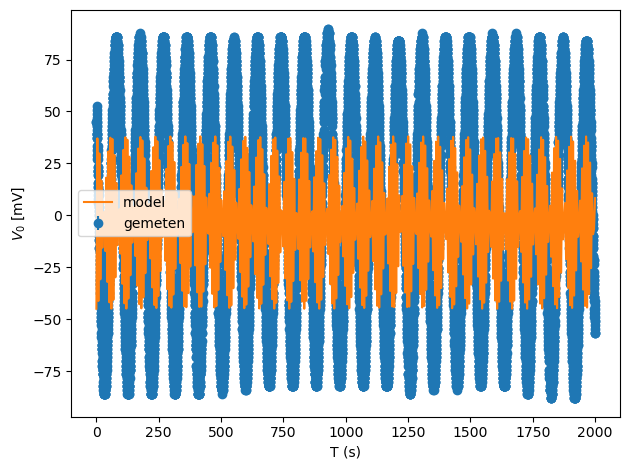

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 6304215252.949122
             x: [ 1.768e+04 -5.378e-02  3.585e-03 -1.577e+00]
           nit: 424
          nfev: 800
 final_simplex: (array([[ 1.768e+04, -5.378e-02,  3.585e-03, -1.577e+00],
                       [ 1.768e+04, -5.378e-02,  3.585e-03, -1.577e+00],
                       ...,
                       [ 1.768e+04, -5.378e-02,  3.585e-03, -1.577e+00],
                       [ 1.768e+04, -5.378e-02,  3.585e-03, -1.577e+00]]), array([ 6.304e+09,  6.304e+09,  6.304e+09,  6.304e+09,
                        6.304e+09]))
[[8842.288741947219, 26526.916479272753], [-0.056837802050074764, -0.0507086417471137], [0.0065127315855143695, 0.006512731679293209], [-1.5795028068388968, -1.5751690190305605]]
omega heeft als waarde: 17685 + 8842.3 - 8842.3 met 68% betrouwbaarheidsinterval: [8842.3, 26527] 
p_0_x heeft als waarde: -0.053778 + 0.0030696 

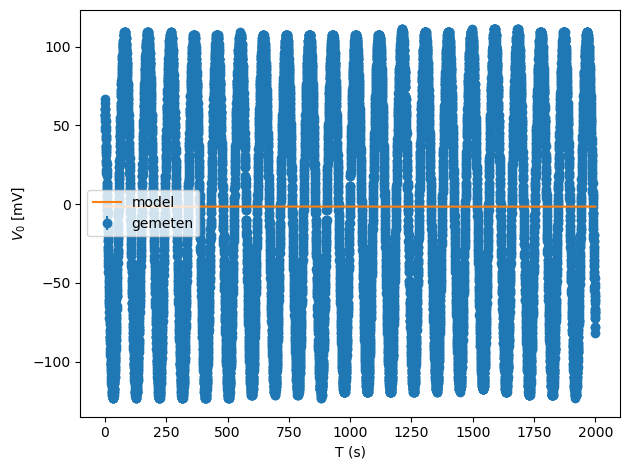

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10571812705.904877
             x: [ 1.954e+04  5.200e+00  7.633e-04  1.106e+01]
           nit: 348
          nfev: 694
 final_simplex: (array([[ 1.954e+04,  5.200e+00,  7.633e-04,  1.106e+01],
                       [ 1.954e+04,  5.200e+00,  7.633e-04,  1.106e+01],
                       ...,
                       [ 1.954e+04,  5.200e+00,  7.633e-04,  1.106e+01],
                       [ 1.954e+04,  5.200e+00,  7.633e-04,  1.106e+01]]), array([ 1.057e+10,  1.057e+10,  1.057e+10,  1.057e+10,
                        1.057e+10]))
[[9770.337548125019, 29310.988527710528], [5.199863514287077, 5.199863514287133], [0.0007632020404327119, 0.0007631937234131367], [11.059694606853034, 11.059694606852961]]
omega heeft als waarde: 19541 + 9770.4 - 9770.3 met 68% betrouwbaarheidsinterval: [9770.3, 29311] 
p_0_x heeft als waarde: 5.1999 + -1.9413e-07 - 1.9413e-07 met 68% betrouw

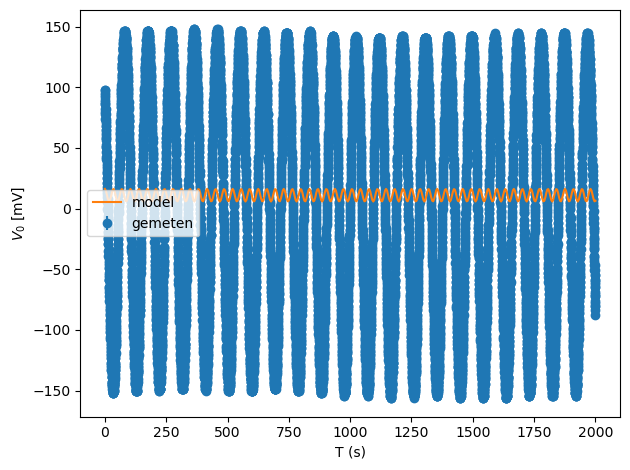

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 3694012258.248521
             x: [ 1.781e+04  8.568e+01  5.450e-03 -3.946e+01]
           nit: 366
          nfev: 800
 final_simplex: (array([[ 1.781e+04,  8.568e+01,  5.450e-03, -3.946e+01],
                       [ 1.781e+04,  8.568e+01,  5.450e-03, -3.946e+01],
                       ...,
                       [ 1.781e+04,  8.568e+01,  5.450e-03, -3.946e+01],
                       [ 1.781e+04,  8.568e+01,  5.450e-03, -3.946e+01]]), array([ 3.694e+09,  3.694e+09,  3.694e+09,  3.694e+09,
                        3.694e+09]))
[[8906.208189510513, 26719.763362872156], [85.6830289906188, 153.28471796159477], [0.0054502391122891345, 0.005450239150205337], [-39.46497078515095, -39.46497078515066]]
omega heeft als waarde: 17813 + 8907 - 8906.6 met 68% betrouwbaarheidsinterval: [8906.2, 26720] 
p_0_x heeft als waarde: 85.683 + 67.602 - 1.3932e-07 met

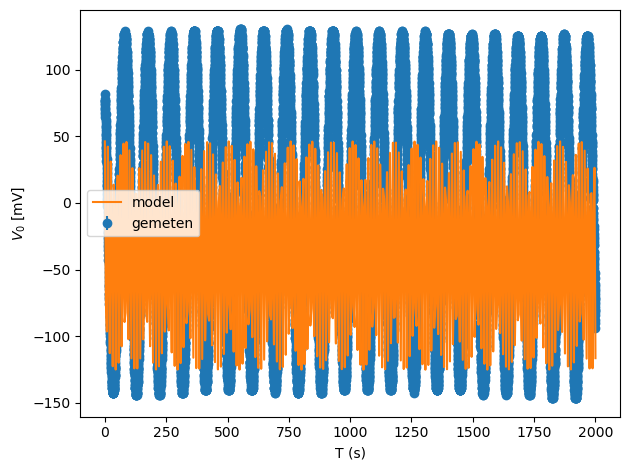

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11686520639.489532
             x: [ 1.780e+04 -3.648e-02  3.910e-03 -3.158e+00]
           nit: 243
          nfev: 465
 final_simplex: (array([[ 1.780e+04, -3.648e-02,  3.910e-03, -3.158e+00],
                       [ 1.780e+04, -3.649e-02,  3.910e-03, -3.158e+00],
                       ...,
                       [ 1.780e+04, -3.648e-02,  3.910e-03, -3.158e+00],
                       [ 1.780e+04, -3.648e-02,  3.910e-03, -3.158e+00]]), array([ 1.169e+10,  1.169e+10,  1.169e+10,  1.169e+10,
                        1.169e+10]))
[[8898.979509450413, 26696.974371836543], [-0.04513248690470525, -0.03539738874459306], [-0.03426447670502175, -0.03426449039023978], [-3.163122714868781, -3.157190690983426]]
omega heeft als waarde: 17798 + 8899 - 8899 met 68% betrouwbaarheidsinterval: [8899, 26697] 
p_0_x heeft als waarde: -0.036484 + 0.0010861 - 0.0086489 met 68% betrouwba

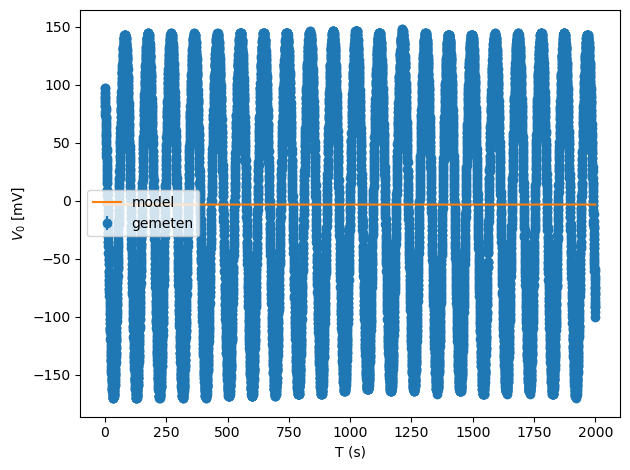

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 13151849530.744694
             x: [ 2.106e+04 -5.923e-01  1.191e-03  2.430e-01]
           nit: 319
          nfev: 648
 final_simplex: (array([[ 2.106e+04, -5.923e-01,  1.191e-03,  2.430e-01],
                       [ 2.106e+04, -5.923e-01,  1.191e-03,  2.430e-01],
                       ...,
                       [ 2.106e+04, -5.923e-01,  1.191e-03,  2.430e-01],
                       [ 2.106e+04, -5.923e-01,  1.191e-03,  2.430e-01]]), array([ 1.315e+10,  1.315e+10,  1.315e+10,  1.315e+10,
                        1.315e+10]))
[[10532.239991682216, 31596.661646009175], [-0.5957216383590428, -0.5895475820852394], [0.0011721387371008151, 0.0011721384677616064], [0.24278594665089484, 0.2688722856390849]]
omega heeft als waarde: 21064 + 10532 - 10532 met 68% betrouwbaarheidsinterval: [10532, 31597] 
p_0_x heeft als waarde: -0.59226 + 0.0027131 - 0.003461 met 68% betrou

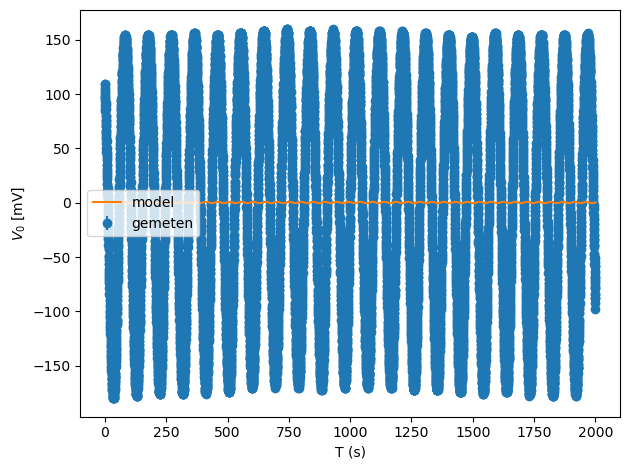

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 2621689171.1584535
             x: [ 1.810e+04  1.505e+02  6.014e-03 -1.422e+01]
           nit: 405
          nfev: 800
 final_simplex: (array([[ 1.810e+04,  1.505e+02,  6.014e-03, -1.422e+01],
                       [ 1.810e+04,  1.505e+02,  6.014e-03, -1.422e+01],
                       ...,
                       [ 1.810e+04,  1.505e+02,  6.014e-03, -1.422e+01],
                       [ 1.810e+04,  1.505e+02,  6.014e-03, -1.422e+01]]), array([ 2.622e+09,  2.622e+09,  2.622e+09,  2.622e+09,
                        2.622e+09]))
[[9047.811764253174, 27143.623625309785], [150.45713759468248, 155.15915194716996], [0.0060143722420950025, 0.006014372236528245], [-14.220022409661512, -14.22002240966138]]
omega heeft als waarde: 18096 + 9048 - 9047.8 met 68% betrouwbaarheidsinterval: [9047.8, 27144] 
p_0_x heeft als waarde: 150.46 + 4.702 - 2.0036e-06 

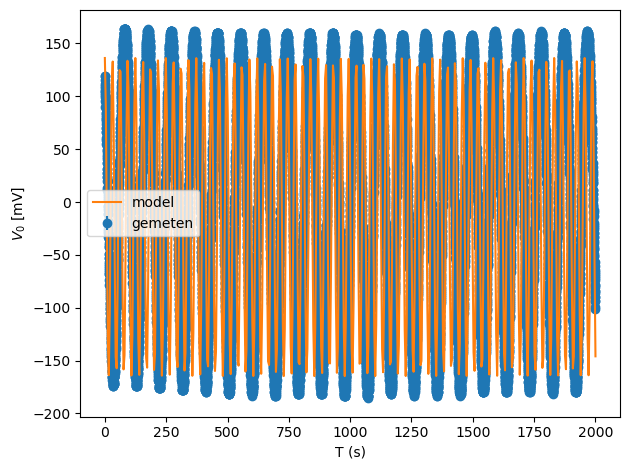

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 13238642035.198055
             x: [ 2.031e+04 -2.343e-02  4.477e-03  4.235e+00]
           nit: 210
          nfev: 462
 final_simplex: (array([[ 2.031e+04, -2.343e-02,  4.477e-03,  4.235e+00],
                       [ 2.031e+04, -2.343e-02,  4.477e-03,  4.235e+00],
                       ...,
                       [ 2.031e+04, -2.343e-02,  4.477e-03,  4.235e+00],
                       [ 2.031e+04, -2.343e-02,  4.477e-03,  4.235e+00]]), array([ 1.324e+10,  1.324e+10,  1.324e+10,  1.324e+10,
                        1.324e+10]))
[[10154.212287384858, 30462.643479309005], [-0.02319756904579132, -0.023197569043986288], [0.03240610350188612, 0.0324061092626882], [4.233987425484222, 4.239450040329874]]
omega heeft als waarde: 20308 + 10154 - 10154 met 68% betrouwbaarheidsinterval: [10154, 30463] 
p_0_x heeft als waarde: -0.023432 + 0.00023416 - -0.00023416 met 68% betrou

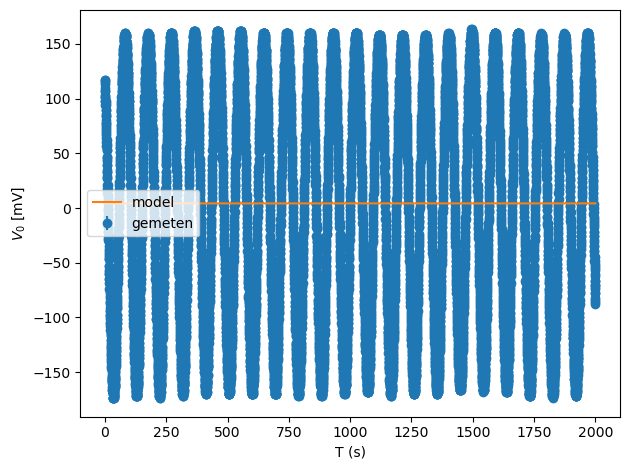

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10246322271.249603
             x: [ 2.104e+04 -3.735e-02  2.156e-03  6.526e+00]
           nit: 137
          nfev: 285
 final_simplex: (array([[ 2.104e+04, -3.735e-02,  2.156e-03,  6.526e+00],
                       [ 2.104e+04, -3.735e-02,  2.156e-03,  6.526e+00],
                       ...,
                       [ 2.104e+04, -3.735e-02,  2.156e-03,  6.526e+00],
                       [ 2.104e+04, -3.735e-02,  2.156e-03,  6.526e+00]]), array([ 1.025e+10,  1.025e+10,  1.025e+10,  1.025e+10,
                        1.025e+10]))
[[10519.0255562171, 31557.073195134493], [-0.043730814198250756, -0.035880037790568836], [0.05076296943009142, 0.05076297366771382], [6.525558395789476, 6.53498872767412]]
omega heeft als waarde: 21038 + 10519 - 10519 met 68% betrouwbaarheidsinterval: [10519, 31557] 
p_0_x heeft als waarde: -0.037352 + 0.0014724 - 0.0063783 met 68% betrouwbaa

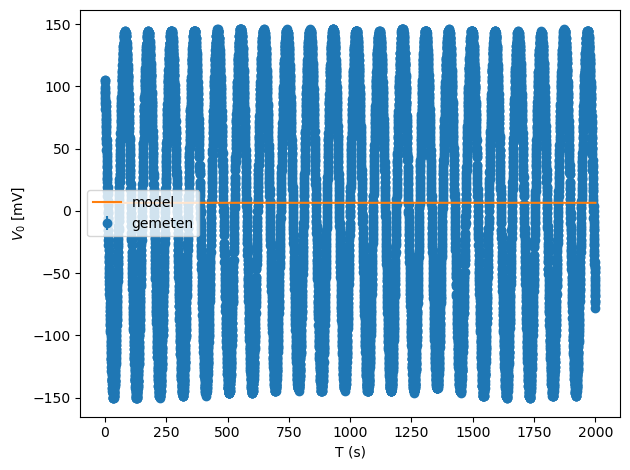

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1237317190.7168517
             x: [ 1.731e+04  7.102e+01 -1.471e-03  3.716e+01]
           nit: 390
          nfev: 774
 final_simplex: (array([[ 1.731e+04,  7.102e+01, -1.471e-03,  3.716e+01],
                       [ 1.731e+04,  7.102e+01, -1.471e-03,  3.716e+01],
                       ...,
                       [ 1.731e+04,  7.102e+01, -1.471e-03,  3.716e+01],
                       [ 1.731e+04,  7.102e+01, -1.471e-03,  3.716e+01]]), array([ 1.237e+09,  1.237e+09,  1.237e+09,  1.237e+09,
                        1.237e+09]))
[[8654.83832763738, 25965.786094180705], [71.02280622562336, 98.0060799538831], [-0.0014714663096667459, -0.0014714663015883548], [37.16247395227217, 37.1624739522731]]
omega heeft als waarde: 17310 + 8655.7 - 8655.3 met 68% betrouwbaarheidsinterval: [8654.8, 25966] 
p_0_x heeft als waarde: 71.023 + 26.983 - 3.4922e-07 met 68% betrouwbaarheid

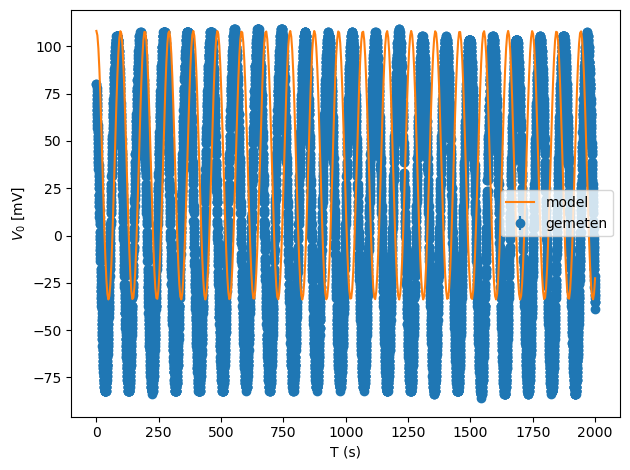

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1388181540.5009704
             x: [ 1.930e+04  5.328e-02  8.730e-04  1.312e+01]
           nit: 243
          nfev: 475
 final_simplex: (array([[ 1.930e+04,  5.328e-02,  8.730e-04,  1.312e+01],
                       [ 1.930e+04,  5.327e-02,  8.730e-04,  1.312e+01],
                       ...,
                       [ 1.930e+04,  5.328e-02,  8.730e-04,  1.312e+01],
                       [ 1.930e+04,  5.327e-02,  8.730e-04,  1.312e+01]]), array([ 1.388e+09,  1.388e+09,  1.388e+09,  1.388e+09,
                        1.388e+09]))
[[9650.691840725405, 28952.08401501301], [0.05039099582264335, 0.056530385636177564], [-0.0036822068582890175, -0.0036822101393801806], [13.101969126643088, 13.124602414068988]]
omega heeft als waarde: 19301 + 9650.7 - 9650.7 met 68% betrouwbaarheidsinterval: [9650.7, 28952] 
p_0_x heeft als waarde: 0.053281 + 0.0032497 - 0.0028897 met 68% be

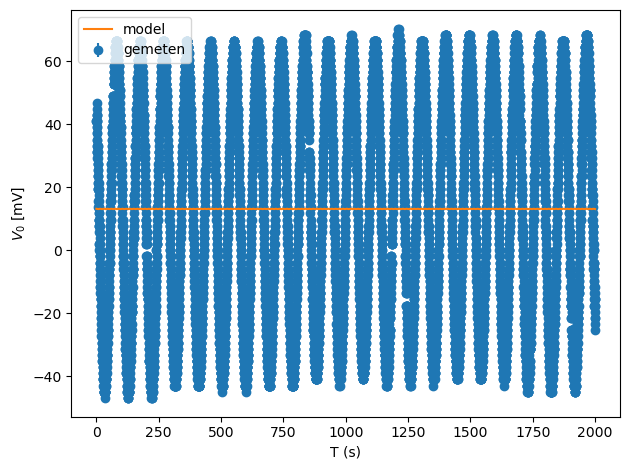

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11878048977.545834
             x: [ 1.788e+04 -2.833e-02  3.518e-03 -1.018e+00]
           nit: 234
          nfev: 462
 final_simplex: (array([[ 1.788e+04, -2.833e-02,  3.518e-03, -1.018e+00],
                       [ 1.788e+04, -2.833e-02,  3.518e-03, -1.018e+00],
                       ...,
                       [ 1.788e+04, -2.834e-02,  3.518e-03, -1.018e+00],
                       [ 1.788e+04, -2.832e-02,  3.518e-03, -1.018e+00]]), array([ 1.188e+10,  1.188e+10,  1.188e+10,  1.188e+10,
                        1.188e+10]))
[[8941.76738801715, 26825.29894402917], [-0.028081555804915944, -0.028081555777988293], [-0.014356865562199127, -0.014356865641106878], [-1.0401411701376286, -1.0176701857216817]]
omega heeft als waarde: 17884 + 8941.8 - 8941.8 met 68% betrouwbaarheidsinterval: [8941.8, 26825] 
p_0_x heeft als waarde: -0.028334 + 0.00025241 - -0.00025241 met 

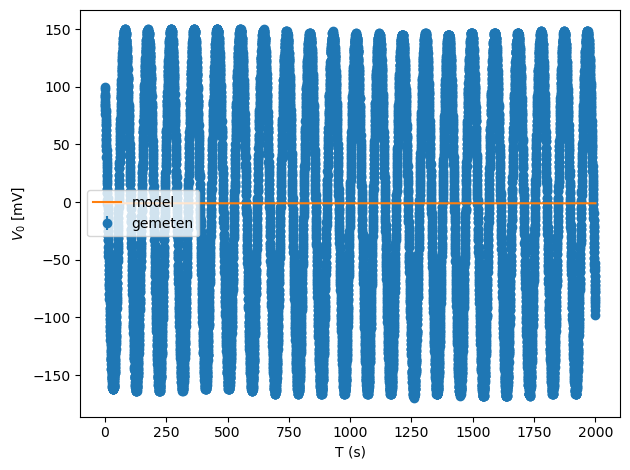

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 85646870.47259778
             x: [ 2.072e+04 -4.084e-02  8.924e-04  1.254e+01]
           nit: 274
          nfev: 522
 final_simplex: (array([[ 2.072e+04, -4.084e-02,  8.924e-04,  1.254e+01],
                       [ 2.072e+04, -4.084e-02,  8.924e-04,  1.254e+01],
                       ...,
                       [ 2.072e+04, -4.082e-02,  8.924e-04,  1.254e+01],
                       [ 2.072e+04, -4.083e-02,  8.924e-04,  1.254e+01]]), array([ 8.565e+07,  8.565e+07,  8.565e+07,  8.565e+07,
                        8.565e+07]))
[[10360.901871236252, 31082.669842940326], [-0.044447013491073675, -0.03823646878918736], [-0.04015168701627986, -0.04015168702846001], [12.537103848614763, 12.551559671183822]]
omega heeft als waarde: 20722 + 10361 - 10361 met 68% betrouwbaarheidsinterval: [10361, 31083] 
p_0_x heeft als waarde: -0.04084 + 0.0026039 - 0.0036067 met 68% betrou

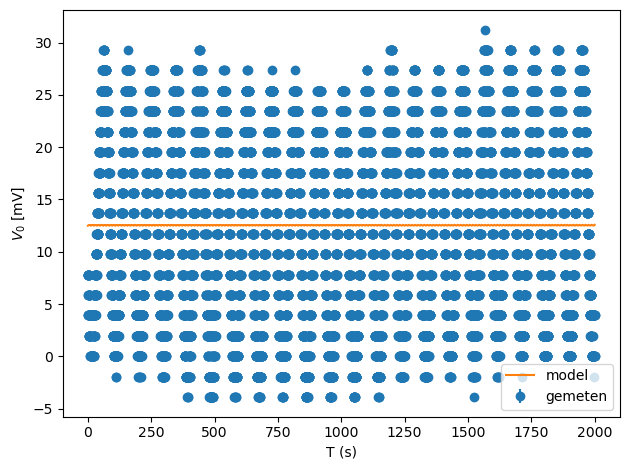

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 518058409.71934646
             x: [ 2.085e+04 -3.105e-02  2.509e-03  8.133e+00]
           nit: 253
          nfev: 475
 final_simplex: (array([[ 2.085e+04, -3.105e-02,  2.509e-03,  8.133e+00],
                       [ 2.085e+04, -3.105e-02,  2.509e-03,  8.133e+00],
                       ...,
                       [ 2.085e+04, -3.104e-02,  2.509e-03,  8.133e+00],
                       [ 2.085e+04, -3.105e-02,  2.509e-03,  8.133e+00]]), array([ 5.181e+08,  5.181e+08,  5.181e+08,  5.181e+08,
                        5.181e+08]))
[[10426.317862736772, 31278.953716718122], [-0.034563106560142644, -0.02837762083864853], [0.049244141233946576, 0.04924414137013437], [8.12892688923628, 8.133965020370878]]
omega heeft als waarde: 20853 + 10426 - 10426 met 68% betrouwbaarheidsinterval: [10426, 31279] 
p_0_x heeft als waarde: -0.031053 + 0.0026756 - 0.0035099 met 68% betrouwb

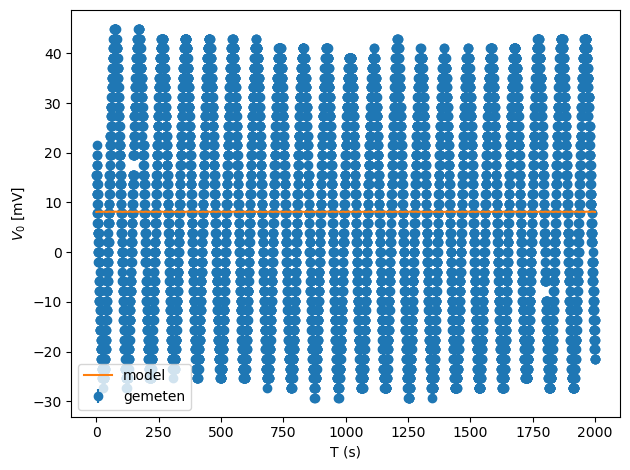

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2368741543.8281536
             x: [ 1.653e+04 -9.965e-02  4.769e-03  5.367e+00]
           nit: 206
          nfev: 394
 final_simplex: (array([[ 1.653e+04, -9.965e-02,  4.769e-03,  5.367e+00],
                       [ 1.653e+04, -9.965e-02,  4.769e-03,  5.367e+00],
                       ...,
                       [ 1.653e+04, -9.965e-02,  4.769e-03,  5.367e+00],
                       [ 1.653e+04, -9.967e-02,  4.769e-03,  5.367e+00]]), array([ 2.369e+09,  2.369e+09,  2.369e+09,  2.369e+09,
                        2.369e+09]))
[[8264.26812953146, 24792.764372223195], [-0.1037016222267413, -0.09733259629457759], [0.012509403359904279, 0.012509405391444536], [5.366675488116669, 5.378610997994031]]
omega heeft als waarde: 16529 + 8264.2 - 8264.2 met 68% betrouwbaarheidsinterval: [8264.3, 24793] 
p_0_x heeft als waarde: -0.099651 + 0.0023182 - 0.0040508 met 68% betrouw

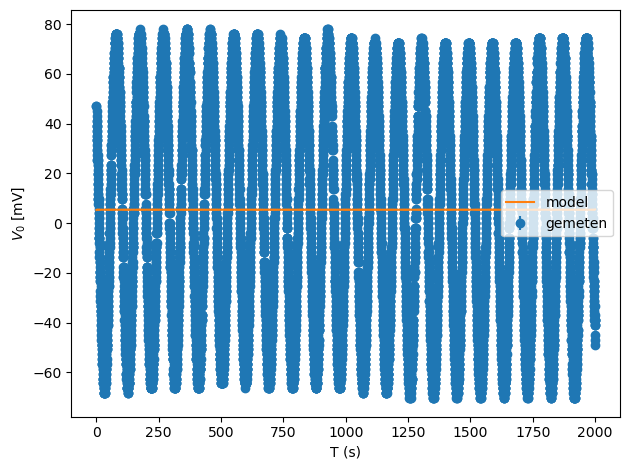

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 4734853196.285477
             x: [ 1.967e+04 -3.332e+01  3.157e-03 -1.596e+01]
           nit: 340
          nfev: 800
 final_simplex: (array([[ 1.967e+04, -3.332e+01,  3.157e-03, -1.596e+01],
                       [ 1.967e+04, -3.332e+01,  3.157e-03, -1.596e+01],
                       ...,
                       [ 1.967e+04, -3.332e+01,  3.157e-03, -1.596e+01],
                       [ 1.967e+04, -3.332e+01,  3.157e-03, -1.596e+01]]), array([ 4.735e+09,  4.735e+09,  4.735e+09,  4.735e+09,
                        4.735e+09]))
[[9833.170475706378, 29499.469858306442], [-33.31973580722826, -33.319735807228234], [0.0031569307526578007, 0.00315693068935812], [-15.959198327255578, -15.95919832725557]]
omega heeft als waarde: 19666 + 9833.2 - 9833.1 met 68% betrouwbaarheidsinterval: [9833.2, 29499] 
p_0_x heeft als waarde: -33.32 + 2.1109e-07 - -2.11

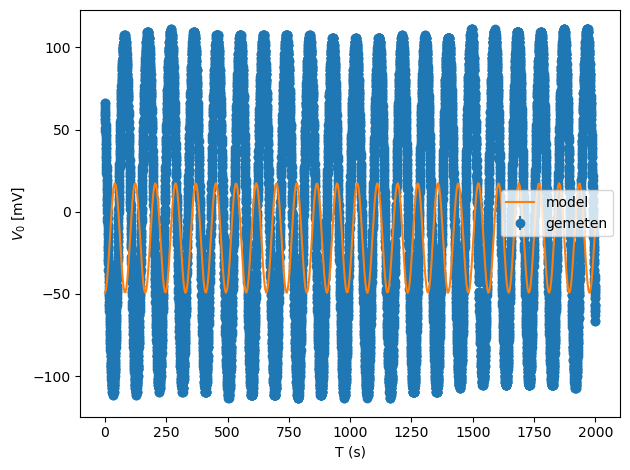

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8183204104.176863
             x: [ 1.840e+04 -5.475e-02  5.234e-04  2.443e+00]
           nit: 319
          nfev: 583
 final_simplex: (array([[ 1.840e+04, -5.475e-02,  5.234e-04,  2.443e+00],
                       [ 1.840e+04, -5.474e-02,  5.234e-04,  2.443e+00],
                       ...,
                       [ 1.840e+04, -5.475e-02,  5.234e-04,  2.443e+00],
                       [ 1.840e+04, -5.476e-02,  5.234e-04,  2.443e+00]]), array([ 8.183e+09,  8.183e+09,  8.183e+09,  8.183e+09,
                        8.183e+09]))
[[9197.989379973036, 27593.965184980363], [-0.05780815051115888, -0.051679389368880245], [0.03778036273661183, 0.037780390270725224], [2.440606368772705, 2.444940162631402]]
omega heeft als waarde: 18396 + 9198 - 9198 met 68% betrouwbaarheidsinterval: [9198, 27594] 
p_0_x heeft als waarde: -0.054746 + 0.0030664 - 0.0030624 met 68% betrouwbaarh

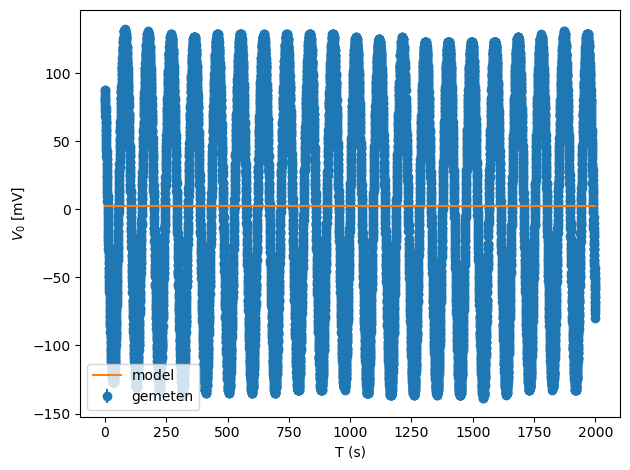

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 7776121658.79965
             x: [ 1.797e+04 -7.057e+01 -1.744e-03 -2.016e+00]
           nit: 447
          nfev: 800
 final_simplex: (array([[ 1.797e+04, -7.057e+01, -1.744e-03, -2.016e+00],
                       [ 1.797e+04, -6.930e+01, -1.701e-03, -1.732e+00],
                       ...,
                       [ 1.797e+04, -7.339e+01, -1.874e-03, -2.470e+00],
                       [ 1.797e+04, -7.124e+01, -1.629e-03, -2.877e+00]]), array([ 7.776e+09,  7.776e+09,  7.777e+09,  7.778e+09,
                        7.778e+09]))
[[8984.889971050501, 26954.769970713136], [-72.71104313095202, -70.57129337208903], [-0.0017441651128579558, -0.0017441650882788005], [-2.015774941761577, -2.015774941762113]]
omega heeft als waarde: 17970 + 8984.9 - 8985 met 68% betrouwbaarheidsinterval: [8984.9, 26955] 
p_0_x heeft als waarde: -70.571 + 4.3786e-06 - 2.139

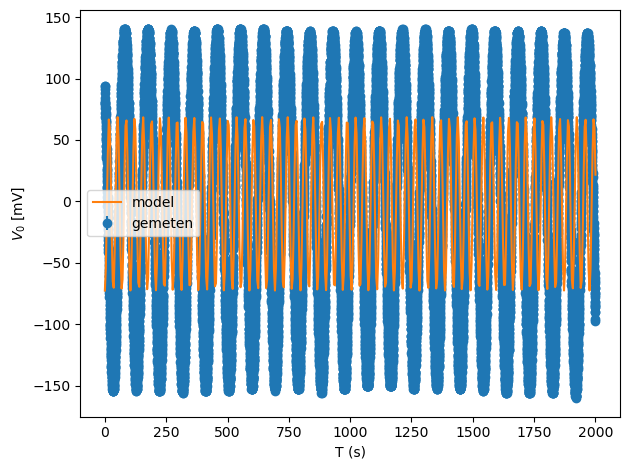

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12076891614.241058
             x: [ 1.835e+04 -1.536e-01  5.693e-04  2.315e+00]
           nit: 308
          nfev: 626
 final_simplex: (array([[ 1.835e+04, -1.536e-01,  5.693e-04,  2.315e+00],
                       [ 1.835e+04, -1.536e-01,  5.693e-04,  2.315e+00],
                       ...,
                       [ 1.835e+04, -1.536e-01,  5.693e-04,  2.315e+00],
                       [ 1.835e+04, -1.536e-01,  5.693e-04,  2.315e+00]]), array([ 1.208e+10,  1.208e+10,  1.208e+10,  1.208e+10,
                        1.208e+10]))
[[9173.17312130385, 27519.505621584594], [-0.18921090851795755, -0.1532888275981609], [0.0007321161628094891, 0.0007321162124619031], [2.2469099241929174, 2.314672830807307]]
omega heeft als waarde: 18346 + 9173.2 - 9173.2 met 68% betrouwbaarheidsinterval: [9173.2, 27520] 
p_0_x heeft als waarde: -0.15355 + 0.00026332 - 0.035659 met 68% betro

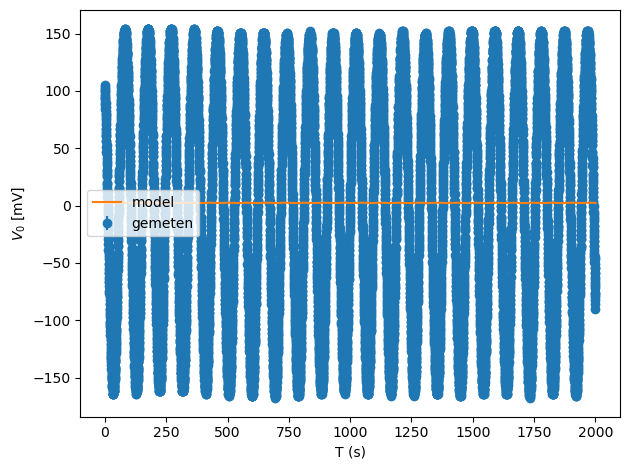

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 11735335330.195337
             x: [ 1.970e+04  1.854e+00  4.279e-03  4.928e+00]
           nit: 352
          nfev: 800
 final_simplex: (array([[ 1.970e+04,  1.854e+00,  4.279e-03,  4.928e+00],
                       [ 1.970e+04,  1.854e+00,  4.279e-03,  4.928e+00],
                       ...,
                       [ 1.970e+04,  1.854e+00,  4.279e-03,  4.928e+00],
                       [ 1.970e+04,  1.854e+00,  4.279e-03,  4.928e+00]]), array([ 1.174e+10,  1.174e+10,  1.174e+10,  1.174e+10,
                        1.174e+10]))
[[9848.826786670827, 29546.413145576622], [0.433238166475948, 1.8541714412847448], [0.004276102404286744, 0.004276101378491184], [4.314068186327656, 4.927846633382534]]
omega heeft als waarde: 19698 + 9848.8 - 9848.8 met 68% betrouwbaarheidsinterval: [9848.8, 29546] 
p_0_x heeft als waarde: 1.8542 + 6.5983e-06 - 1.4209 me

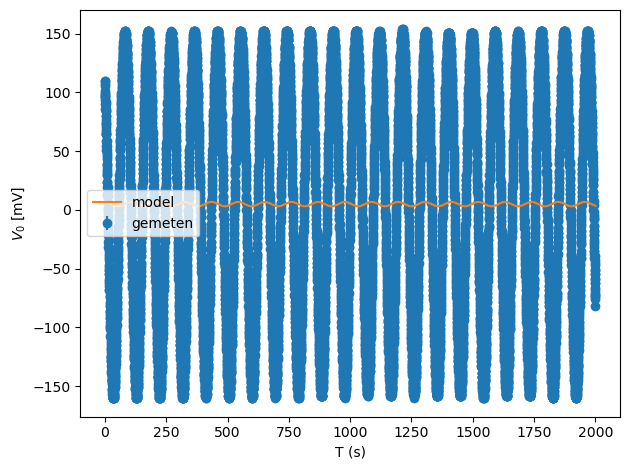

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 10051267421.806044
             x: [ 2.293e+04 -1.248e+01  9.894e-03 -1.307e+01]
           nit: 378
          nfev: 745
 final_simplex: (array([[ 2.293e+04, -1.248e+01,  9.894e-03, -1.307e+01],
                       [ 2.293e+04, -1.248e+01,  9.894e-03, -1.307e+01],
                       ...,
                       [ 2.293e+04, -1.248e+01,  9.894e-03, -1.307e+01],
                       [ 2.293e+04, -1.248e+01,  9.894e-03, -1.307e+01]]), array([ 1.005e+10,  1.005e+10,  1.005e+10,  1.005e+10,
                        1.005e+10]))
[[11466.87813973445, 34400.63800814526], [-12.47890240381096, -12.478902403810938], [0.00989397055979181, 0.009893970492213883], [-13.074937585560052, -13.074937585559923]]
omega heeft als waarde: 22934 + 11467 - 11467 met 68% betrouwbaarheidsinterval: [11467, 34401] 
p_0_x heeft als waarde: -12.479 + 7.9709e-08 - -7.9709e-08 met 68% betrouwb

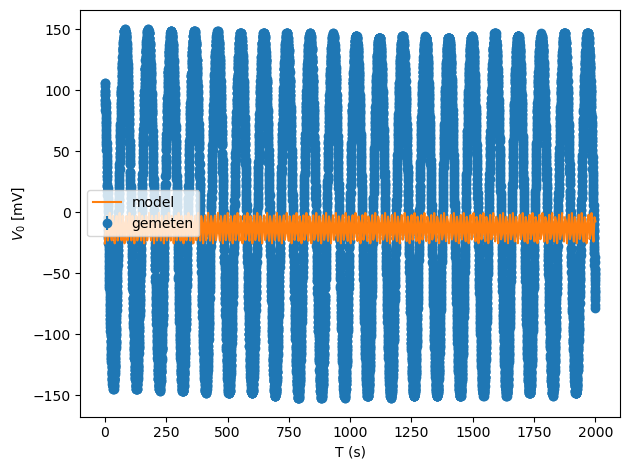

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 9155366136.679441
             x: [ 2.089e+04 -1.198e+01 -1.158e-03  1.595e+01]
           nit: 309
          nfev: 624
 final_simplex: (array([[ 2.089e+04, -1.198e+01, -1.158e-03,  1.595e+01],
                       [ 2.089e+04, -1.198e+01, -1.158e-03,  1.595e+01],
                       ...,
                       [ 2.089e+04, -1.198e+01, -1.158e-03,  1.595e+01],
                       [ 2.089e+04, -1.198e+01, -1.158e-03,  1.595e+01]]), array([ 9.155e+09,  9.155e+09,  9.155e+09,  9.155e+09,
                        9.155e+09]))
[[10445.830943349802, 31337.29428140272], [-11.982589169423237, -11.982589169423097], [-0.0011575772248980916, -0.0011575809312923792], [15.9522811494598, 15.952281149459763]]
omega heeft als waarde: 20892 + 10446 - 10446 met 68% betrouwbaarheidsinterval: [10446, 31337] 
p_0_x heeft als waarde: -11.983 + 3.822e-07 - -3.822e-07 met 68% betrouwb

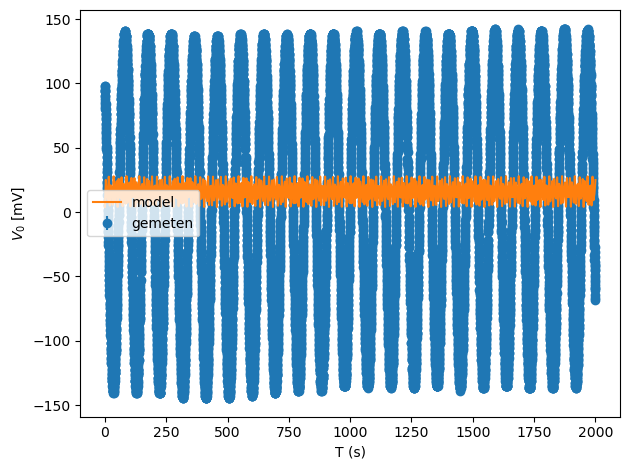

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5941853994.11794
             x: [ 2.069e+04 -1.253e-01  1.408e-03  9.531e+00]
           nit: 248
          nfev: 471
 final_simplex: (array([[ 2.069e+04, -1.253e-01,  1.408e-03,  9.531e+00],
                       [ 2.069e+04, -1.253e-01,  1.408e-03,  9.531e+00],
                       ...,
                       [ 2.069e+04, -1.253e-01,  1.408e-03,  9.531e+00],
                       [ 2.069e+04, -1.253e-01,  1.408e-03,  9.531e+00]]), array([ 5.942e+09,  5.942e+09,  5.942e+09,  5.942e+09,
                        5.942e+09]))
[[10343.700179632038, 31031.090129780194], [-0.12528953068910967, -0.125289530687733], [0.0013489955888884757, 0.0013489959482126945], [9.530804056893555, 9.933631908557697]]
omega heeft als waarde: 20687 + 10344 - 10344 met 68% betrouwbaarheidsinterval: [10344, 31031] 
p_0_x heeft als waarde: -0.1253 + 6.9021e-06 - -6.9021e-06 met 68% betrouwb

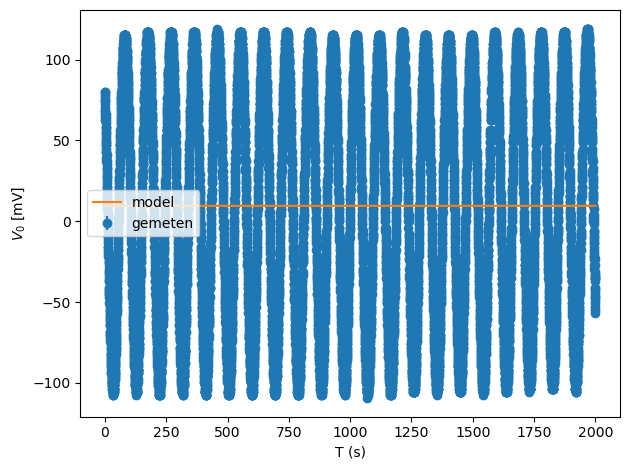

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1671812368.6629398
             x: [ 2.114e+04  6.519e+01 -8.406e-03  3.466e+01]
           nit: 397
          nfev: 796
 final_simplex: (array([[ 2.114e+04,  6.519e+01, -8.406e-03,  3.466e+01],
                       [ 2.114e+04,  6.519e+01, -8.406e-03,  3.466e+01],
                       ...,
                       [ 2.114e+04,  6.519e+01, -8.406e-03,  3.466e+01],
                       [ 2.114e+04,  6.519e+01, -8.406e-03,  3.466e+01]]), array([ 1.672e+09,  1.672e+09,  1.672e+09,  1.672e+09,
                        1.672e+09]))
[[10572.173095748443, 31714.33410640716], [65.19405764528109, 106.0105282146596], [-0.008405774146311953, -0.008405774141355868], [34.65589340349362, 34.65589340349363]]
omega heeft als waarde: 21143 + 10571 - 10571 met 68% betrouwbaarheidsinterval: [10572, 31714] 
p_0_x heeft als waarde: 65.194 + 40.816 - 2.3079e-07 met 68% betrouwbaarheidsi

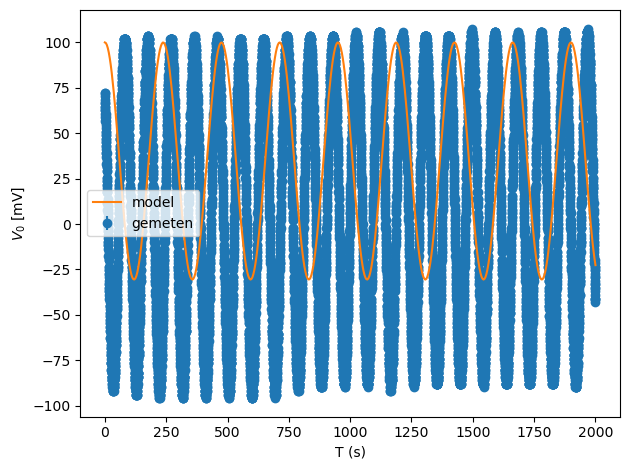

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1677100813.116169
             x: [ 1.891e+04 -3.452e+01  5.981e-04  1.234e+01]
           nit: 367
          nfev: 800
 final_simplex: (array([[ 1.891e+04, -3.452e+01,  5.981e-04,  1.234e+01],
                       [ 1.891e+04, -3.452e+01,  5.981e-04,  1.234e+01],
                       ...,
                       [ 1.891e+04, -3.452e+01,  5.981e-04,  1.234e+01],
                       [ 1.891e+04, -3.452e+01,  5.981e-04,  1.234e+01]]), array([ 1.677e+09,  1.677e+09,  1.677e+09,  1.677e+09,
                        1.677e+09]))
[[9456.217383264688, 28368.640339435922], [-35.43305062258282, -34.52452848989047], [0.0005981372852867883, 0.0005981372857506187], [5.320751561421482, 12.342703244646458]]
omega heeft als waarde: 18912 + 9456.2 - 9456.2 met 68% betrouwbaarheidsinterval: [9456.2, 28369] 
p_0_x heeft als waarde: -34.525 + 1.0313e-05 - 0.908

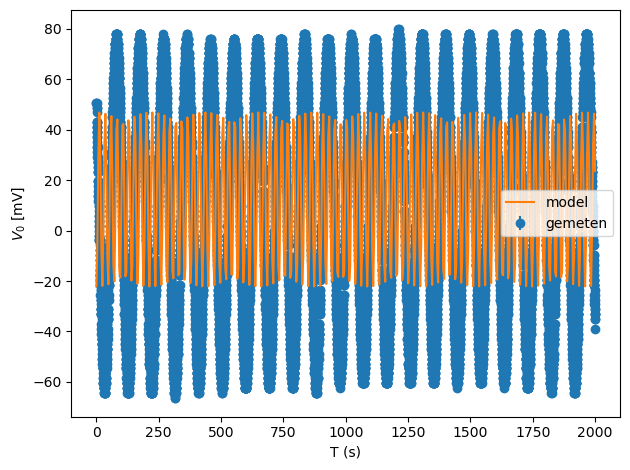

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 939017889.7705901
             x: [ 2.001e+04 -1.399e-01  9.999e-04  1.244e+01]
           nit: 294
          nfev: 562
 final_simplex: (array([[ 2.001e+04, -1.399e-01,  9.999e-04,  1.244e+01],
                       [ 2.001e+04, -1.399e-01,  9.999e-04,  1.244e+01],
                       ...,
                       [ 2.001e+04, -1.399e-01,  9.999e-04,  1.244e+01],
                       [ 2.001e+04, -1.399e-01,  9.999e-04,  1.244e+01]]), array([ 9.390e+08,  9.390e+08,  9.390e+08,  9.390e+08,
                        9.390e+08]))
[[10005.890043414318, 30018.12281744426], [-0.2208800702497368, -0.1398102286360654], [0.001188423237436198, 0.0011884235005585352], [12.442772448164714, 12.54744405866342]]
omega heeft als waarde: 20012 + 10006 - 10006 met 68% betrouwbaarheidsinterval: [10006, 30018] 
p_0_x heeft als waarde: -0.13993 + 0.00011587 - 0.080954 met 68% betrouwbaa

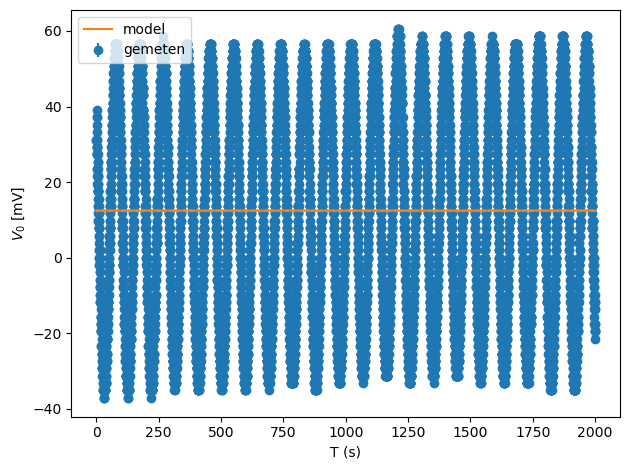

Raw output
       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 92848694222191.98
             x: [ 7.930e+00  1.996e+01 -3.689e+00 -7.202e-01]
           nit: 486
          nfev: 800
 final_simplex: (array([[ 7.930e+00,  1.996e+01, -3.689e+00, -7.202e-01],
                       [ 7.930e+00,  1.996e+01, -3.689e+00, -7.202e-01],
                       ...,
                       [ 7.931e+00,  1.996e+01, -3.689e+00, -7.201e-01],
                       [ 7.930e+00,  1.996e+01, -3.689e+00, -7.202e-01]]), array([ 9.285e+13,  9.285e+13,  9.285e+13,  9.285e+13,
                        9.285e+13]))
[[7.892558846627573, 7.930166117647601], [19.956940852130845, 19.993120961058164], [-3.6889185269226834, -47.671180787671815], [-0.7202557649774658, -0.7202328362403331]]
k heeft als waarde: 7.9302 + 4.0412e-13 - 0.037607 met 68% betrouwbaarheidsinterval: [7.8926, 7.9302] 
p_0 heeft als waarde: 19.957 + 0.03618 - 1.8154e-1

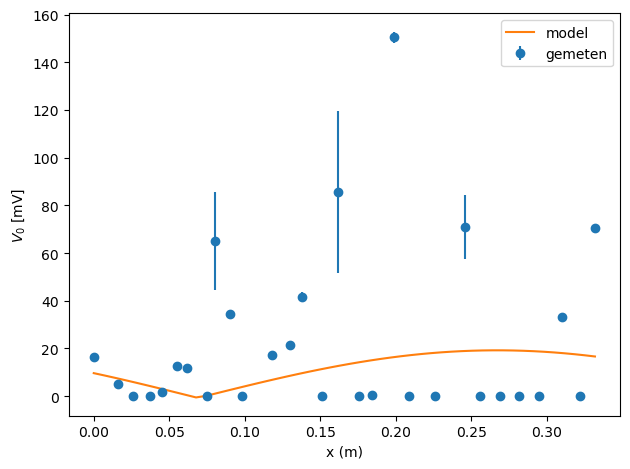

datapunt: v = [2423.30407964553, 225.075921914210, 'Normaal']


In [139]:
#experiment 1: 1000 Hz, 35,3cm
mypath = "metingen laweit/1000Hz, 35.3cm"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
afstanden = []
T = []
V = []
for filenaam in onlyfiles:
    nummer = float(filenaam[9:-4])*10**(-3)
    afstanden.append(nummer)
    bestand = open(mypath + '/' +filenaam,'rt')
    inhoud = bestand.read()
    bestand.close()
    Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
    if nummer != 0:
        assert eenheid0 == eenheid
    else:
        eenheid0 = eenheid
    V.append(Vpart.copy())
    T.append(Tpart.copy())
V = np.array(V)
afstanden = np.array(afstanden)
T = np.array(T)
V_fout = np.full(np.shape(V), 0.1) #euhm pls help, ik heb hier 0.1 mV genomen als de fout op de spanning
fix_data(afstanden, T, V, V_fout, invals_vaste_x)
